In [1]:
import quandl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
quandl.ApiConfig.api_key = 'xoxox'

In [2]:
def fix_nan(data, fix):
    idx = np.isnan(data)
    if isinstance(fix, (pd.core.series.Series, np.ndarray)):
        data[idx] = fix[idx]
        return
    data[idx] = fix
    
def first_valid_obs(data):
    x = np.square(data)
    fix_nan(x, 0)
    return np.where(np.cumsum(x) > 0)[0][0]

def ewma_moment(data, moment, decay_in_days, ignore_zeros=True):
    res =  np.nan * np.ones(data.shape)
    alpha = 1 - 1 / (1 + decay_in_days)
    fst_idx = first_valid_obs(data)
    seeded_value = np.nanmean(data[fst_idx : fst_idx + decay_in_days - 1] ** moment)
    res[fst_idx : fst_idx + decay_in_days - 1] = seeded_value
    for k in np.arange(fst_idx + decay_in_days - 1, len(data)):
        if np.isnan(data[k]) or (ignore_zeros and data[k] == 0):
            res[k] = res[k-1]
        else:
            res[k] = alpha * res[k-1] + (1 - alpha) * (data[k] ** moment)
    return res

def winsorize(x, window=1, low_quantile=0, high_quantile=1):
    if low_quantile==0 and high_quantile==1:
        return x
    if low_quantile==0 and high_quantile<1:
        high = x.rolling(window=window).quantile(high_quantile, interpolation='midpoint')
        fix_nan(high, x)
        return pd.Series(data=np.min([x.values, high.values], axis=0), index=x.index)
    if high_quantile==1 and low_quantile>0:
        low = x.rolling(window=window).quantile(low_quantile, interpolation='midpoint')
        fix_nan(low, x)
        return pd.Series(data=np.max([x.values, low.values], axis=0), index=x.index) 
    low = x.rolling(window=window).quantile(low_quantile, interpolation='midpoint')
    fix_nan(low, x)
    high = x.rolling(window=window).quantile(high_quantile, interpolation='midpoint')
    fix_nan(high, x)
    return pd.Series(data=np.min([np.max([x.values, low.values], axis=0), high.values], axis=0), index=x.index) 

def draw_down(data): 
    r = np.concatenate((np.arange(0,1), np.cumsum(data))) 
    return r - np.maximum.accumulate(r), r

def max_draw_down(data):
    dd, r = draw_down(data)
    mdd = np.min(dd)
    end = np.argmin(dd)
    start = np.argmax(r[:end])
    return mdd, start, end

def nice_plot(x, label):
    ax = x.plot()
    ax.grid(True)
    ax.set_ylabel(label, fontsize=12)
    ax.xaxis.label.set_visible(False)

def describe(x, label):
    x.hist(bins=50)
    plt.suptitle(label)
    print(x.describe())
    
def pnl_stat(x):
    res = dict()
    res['mean'] = x.mean()
    res['std'] = x.std()
    res['sharpe'] = np.sqrt(252)*res['mean']/res['std']
    mdd, start, end = max_draw_down(x.values)
    res['mdd'] = mdd 
    res['mdd_start_date']  = x.index[start]
    res['mdd_end_date']  = x.index[end]
    res['mdd_depth']  = x.index[end] - x.index[start]
    res['autocorr'] = x.autocorr(1)
    res['% win'] = (x>0).mean()
    return res
    
def score_card(x):
    grp = x.groupby([(data.index.year),(data.index.month)])
    return np.sqrt(252)*grp.mean().unstack(1)/grp.std().unstack(1), grp.sum().unstack(1), grp.std().unstack(1)

In [3]:
#BITFINEX/BTCEUR
data = quandl.get(dataset=["BITFINEX/ETHUSD","BITFINEX/BTCUSD"], authtoken= "MkSMzJtDBEVXHyQDKgF_", collapse="daily")

In [4]:
data.columns.to_list()

['BITFINEX/ETHUSD - High',
 'BITFINEX/ETHUSD - Low',
 'BITFINEX/ETHUSD - Mid',
 'BITFINEX/ETHUSD - Last',
 'BITFINEX/ETHUSD - Bid',
 'BITFINEX/ETHUSD - Ask',
 'BITFINEX/ETHUSD - Volume',
 'BITFINEX/BTCUSD - High',
 'BITFINEX/BTCUSD - Low',
 'BITFINEX/BTCUSD - Mid',
 'BITFINEX/BTCUSD - Last',
 'BITFINEX/BTCUSD - Bid',
 'BITFINEX/BTCUSD - Ask',
 'BITFINEX/BTCUSD - Volume']

In [5]:
data = data.rename(columns=
                   {'BITFINEX/ETHUSD - High' : 'ETHUSD - High',
                    'BITFINEX/ETHUSD - Low' : 'ETHUSD - Low',
                    'BITFINEX/ETHUSD - Mid' : 'ETHUSD - Mid',
                    'BITFINEX/ETHUSD - Last' : 'ETHUSD - Last',
                    'BITFINEX/ETHUSD - Bid' : 'ETHUSD - Bid',
                    'BITFINEX/ETHUSD - Ask' : 'ETHUSD - Ask',
                    'BITFINEX/ETHUSD - Volume' : 'ETHUSD - Volume',
                    'BITFINEX/BTCUSD - High' : 'BTCUSD - High',
                    'BITFINEX/BTCUSD - Low' : 'BTCUSD - Low',
                    'BITFINEX/BTCUSD - Mid' : 'BTCUSD - Mid',
                    'BITFINEX/BTCUSD - Last' : 'BTCUSD - Last',
                    'BITFINEX/BTCUSD - Bid' :'BTCUSD - Bid',
                    'BITFINEX/BTCUSD - Ask': 'BTCUSD - Ask',
                    'BITFINEX/BTCUSD - Volume': 'BTCUSD - Volume'}
                  )

In [6]:
fix_nan(data, 0)

In [7]:
data

,ETHUSD - High,ETHUSD - Low,ETHUSD - Mid,ETHUSD - Last,ETHUSD - Bid,ETHUSD - Ask,ETHUSD - Volume,BTCUSD - High,BTCUSD - Low,BTCUSD - Mid,BTCUSD - Last,BTCUSD - Bid,BTCUSD - Ask,BTCUSD - Volume
Date,,,,,,,,,,,,,,
2014-04-15,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,513.9000,452.000000,504.235000,505.000000,503.500000,504.970000,21013.584774
2014-04-16,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,547.0000,495.000000,537.500000,538.000000,537.000000,538.000000,29633.358705
2014-04-17,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,538.5000,486.100000,507.020000,508.000000,506.040000,508.000000,20709.783819
2014-04-18,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,509.0000,474.250000,483.770000,482.750000,482.750000,484.790000,10458.045243
2014-04-19,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,513.9899,473.830000,505.010650,507.499900,502.531300,507.490000,8963.618369
2014-04-20,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,517.9950,492.200000,500.745753,501.440000,500.071506,501.420000,4921.588803
2014-04-21,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,515.6460,485.000000,497.090000,497.000000,497.000000,497.180000,8132.144453
2014-04-22,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,506.0000,488.800000,491.300003,491.200000,491.209991,491.390015,3105.516105
2014-04-23,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,496.0000,482.880000,490.819500,490.030000,490.040000,491.599000,4716.703433


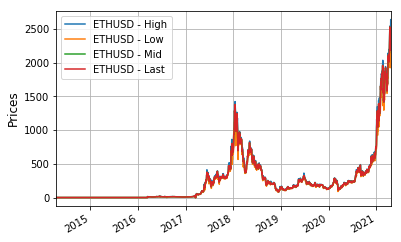

In [8]:
nice_plot(data[['ETHUSD - High', 'ETHUSD - Low', 'ETHUSD - Mid', 'ETHUSD - Last']], 'Prices')

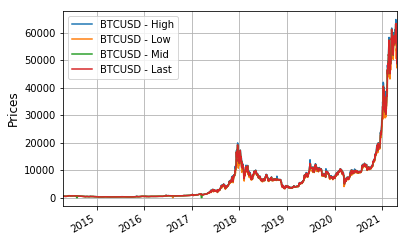

In [9]:
nice_plot(data[['BTCUSD - High', 'BTCUSD - Low', 'BTCUSD - Mid', 'BTCUSD - Last']], 'Prices')

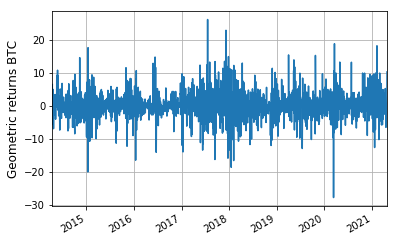

In [10]:
data = data = pd.DataFrame(data[['BTCUSD - Last', 'ETHUSD - Last']])
data.rename(columns={'BTCUSD - Last':'Prices BTC', 'ETHUSD - Last':'Prices ETH'}, inplace=True)
data.index = pd.to_datetime(data.index)

data['A_returns BTC']  = data['Prices BTC'].diff()
data['G_returns BTC']  = data['A_returns BTC'] / data['Prices BTC'].shift()
data['A_returns ETH']  = data['Prices ETH'].diff()
data['G_returns ETH']  = data['A_returns ETH'] / data['Prices ETH'].shift()
                                
nice_plot(100*data['G_returns BTC'], 'Geometric returns BTC')

count    2520.000000
mean        0.259589
std         3.851076
min       -27.769959
25%        -1.321445
50%         0.128538
75%         1.825353
max        26.254826
Name: G_returns BTC, dtype: float64


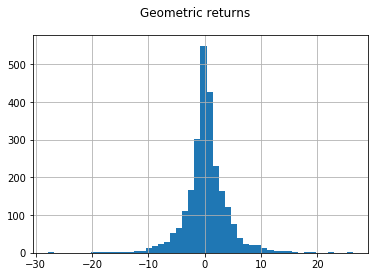

In [11]:
describe(100*data['G_returns BTC'], 'Geometric returns')

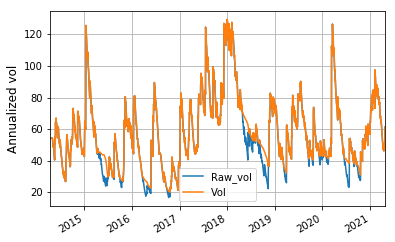

In [12]:
vol_window = 252
vol_low_quantile = 0.15
vol_high_quantile = 1.00
vol_decay_in_days = 18

data['Raw_vol'] = np.sqrt(ewma_moment(data['G_returns BTC'].values, 2, vol_decay_in_days)) 
data['Vol'] = winsorize(data['Raw_vol'], vol_window, vol_low_quantile, vol_high_quantile)
data['Vol_1Lot'] = data['Vol'] * data['Prices BTC']

nice_plot((100*np.sqrt(252)*data[['Raw_vol', 'Vol']]), 'Annualized vol')

           Raw_vol          Vol
count  2520.000000  2520.000000
mean     56.714566    57.932659
std      23.098236    22.146026
min      16.630314    19.998724
25%      41.022065    42.950717
50%      52.634720    53.278734
75%      70.844569    70.867147
max     129.420387   129.420387


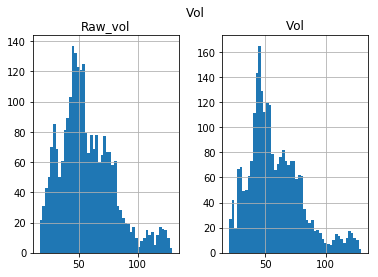

In [13]:
describe(100*np.sqrt(252)*data[['Raw_vol', 'Vol']], 'Vol')

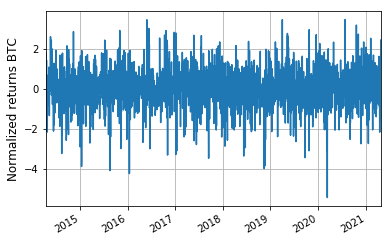

In [14]:
data['N_returns BTC'] = data['A_returns BTC'] / data['Vol_1Lot']

nice_plot(data['N_returns BTC'], 'Normalized returns BTC')

count    2520.000000
mean        0.038045
std         0.928709
min        -5.421931
25%        -0.417306
50%         0.042353
75%         0.541780
max         3.453737
Name: N_returns BTC, dtype: float64


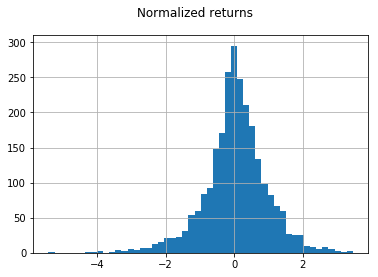

In [15]:
describe(data['N_returns BTC'], 'Normalized returns')

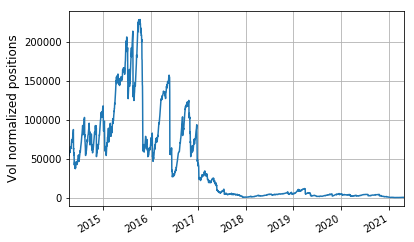

In [16]:
daily_risk = 1000000

data['VN_positions'] =  daily_risk / data['Vol_1Lot']
data['VN_trades'] = data['VN_positions'].diff()
data['VN_PnL'] = data['VN_positions'].shift(1) * data['A_returns BTC']
fix_nan(data['VN_PnL'],0)

nice_plot(data['VN_positions'], 'Vol normalized positions')

count      2520.000000
mean      41927.861316
std       54419.137935
min         333.617603
25%        3301.625038
50%        6410.247038
75%       71942.859990
max      229343.204292
Name: VN_positions, dtype: float64


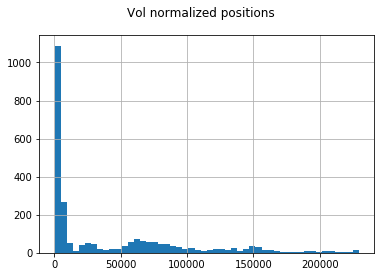

In [17]:
describe(data['VN_positions'], 'Vol normalized positions')

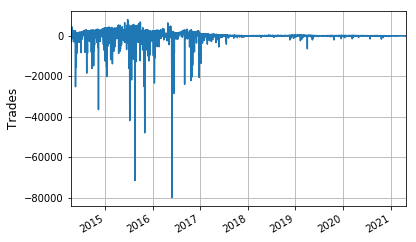

In [18]:
nice_plot(data['VN_trades'], 'Trades')

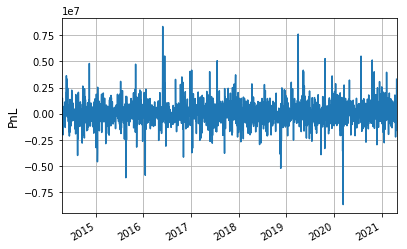

In [19]:
nice_plot(data['VN_PnL'], 'PnL')

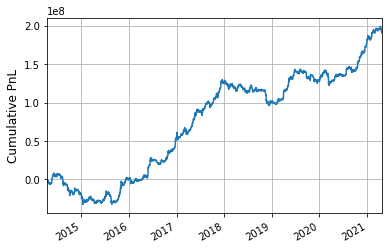

In [20]:
nice_plot(data['VN_PnL'].cumsum(), 'Cumulative PnL')

In [21]:
pnl_stat(data['VN_PnL'])

{'mean': 76805.95664163532,
 'std': 1051091.2935836774,
 'sharpe': 1.1599913064982452,
 'mdd': -40569120.80348619,
 'mdd_start_date': Timestamp('2014-07-03 00:00:00'),
 'mdd_end_date': Timestamp('2015-01-15 00:00:00'),
 'mdd_depth': Timedelta('196 days 00:00:00'),
 'autocorr': 0.03751376112829657,
 '% win': 0.528758429194764}

In [22]:
sharpe, pnl, risk = score_card(data[['VN_PnL']])
round(sharpe, 1)

VN_PnL                                                       
Date     1    2    3    4    5    6    7    8    9    10   11   12
Date                                                              
2014    NaN  NaN  NaN -5.9  5.5  0.6 -3.2 -3.9 -3.9 -2.2  2.5 -3.3
2015   -3.6  2.6 -0.8 -0.8 -1.0  4.6  2.2 -4.2  1.2  8.6  3.2  2.2
2016   -2.0  5.0 -1.4  3.1  3.6  3.7 -1.7 -4.4  2.4  5.1  0.9  7.7
2017    0.6  6.6 -1.1  8.0  5.9  1.4  1.5  7.3 -1.0  5.8  4.4  2.9
2018   -1.2  0.3 -4.4  3.8 -3.7 -2.1  3.3 -1.4 -1.1 -1.2 -5.6 -0.0
2019   -1.7  2.7  2.8  4.3  5.8  3.6 -1.5 -0.5 -3.2  1.1 -3.8 -0.8
2020    5.0 -1.4 -2.3  4.5  1.5 -1.0  4.3  0.9 -1.7  5.6  5.3  6.3
2021    1.9  3.8  3.9 -1.5  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

### Signal

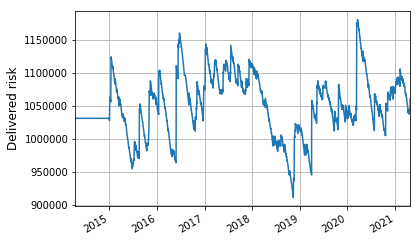

In [23]:
realized_vol = pd.Series(data=np.sqrt(ewma_moment(data['VN_PnL'], 2, 252, False)), index=data.index)

nice_plot(realized_vol, 'Delivered risk')

count    2.519000e+03
mean     1.050115e+06
std      4.601684e+04
min      9.105783e+05
25%      1.026591e+06
50%      1.048710e+06
75%      1.082826e+06
max      1.181000e+06
dtype: float64


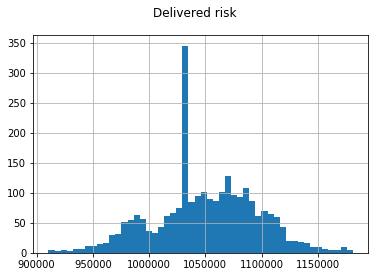

In [24]:
describe(realized_vol, 'Delivered risk')

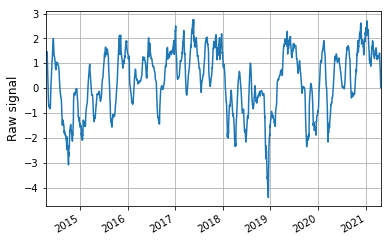

In [60]:
raw_signal_fast_window = 10
fast = ewma_moment(data['Prices BTC'], 1, raw_signal_fast_window) 

raw_signal_slow_window = 20
slow = ewma_moment(data['Prices BTC'], 1, raw_signal_slow_window)

data['R_Signals'] = (fast - slow) / data['Vol_1Lot']

nice_plot(data['R_Signals'], 'Raw signal')

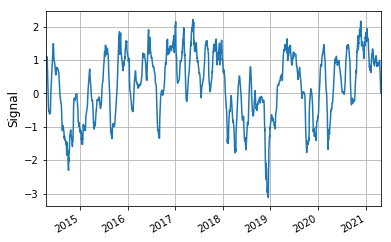

In [61]:
signal_adjustment_decay_in_days = 252
norm = np.sqrt(ewma_moment(data['R_Signals'].values, 2, signal_adjustment_decay_in_days))
data['A_Signals'] = data['R_Signals'] / norm

nice_plot(data['A_Signals'], 'Signal')

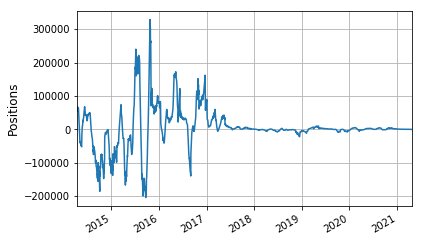

In [62]:
data['Positions'] = data['A_Signals'] * data['VN_positions']
data['Trades'] = data['Positions'].diff()
data['PnL'] = data['Positions'].shift(1) * data['A_returns BTC']
fix_nan(data['PnL'],0)

nice_plot(data['Positions'], 'Positions')

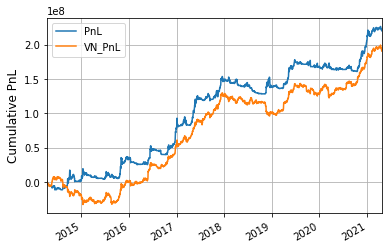

In [63]:
nice_plot(data[['PnL','VN_PnL']].cumsum(), 'Cumulative PnL')

In [52]:
sharpe, pnl, risk = score_card(data[['PnL']])
round(sharpe, 1)

PnL                                                       
Date   1    2    3    4    5    6    7    8    9    10   11   12
Date                                                            
2014  NaN  NaN  NaN -5.7 -1.4 -1.1 -4.4  2.4  3.2  1.5 -4.0  0.6
2015  2.9 -2.9 -3.2 -0.8 -0.9  1.1  2.0 -1.9 -1.8  5.4  2.4  1.4
2016 -2.0 -3.5 -3.5  0.6  2.6  3.4 -1.2 -0.8 -3.7  4.2  0.5  7.8
2017  1.1  5.6 -2.2  5.6  6.1  1.5 -2.9  7.0 -3.0  4.2  3.1  3.0
2018  0.9 -1.6  3.5 -3.4 -2.1  1.1 -4.1 -7.5 -4.2 -1.4  3.5 -0.5
2019  1.0 -3.6  2.3  4.1  6.0  2.7 -2.1 -1.0  1.2 -1.1 -0.7  0.2
2020  0.2 -0.8 -0.2 -3.0  0.6 -0.9  3.4  0.6 -4.4  4.3  4.9  6.1
2021  1.9  2.6  3.4 -3.3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [53]:
round(pnl/daily_risk, 1)

PnL                                                             
Date    1    2    3    4     5     6    7    8     9     10    11    12
Date                                                                   
2014   NaN  NaN  NaN -5.1  -1.4  -2.0 -2.6  4.6  10.4   5.4  -8.2   0.7
2015  11.2 -3.3 -2.7 -1.1  -0.4   0.6  5.2 -3.2  -2.0  13.8  10.6   3.2
2016  -4.5 -1.6 -1.8  0.7   5.5  15.5 -1.2 -0.5  -5.7   9.4   1.7  26.1
2017   4.8  8.2 -7.2  5.3  29.1   3.8 -2.0  8.5  -7.3   7.5   8.7   9.9
2018   0.9 -3.2  4.1 -8.1  -1.2   2.3 -5.8 -5.4  -1.6  -0.3  13.5  -2.4
2019   0.9 -4.2  1.0  9.2  21.7   6.9 -2.3 -0.9   0.5  -4.2  -0.7   0.4
2020   0.2 -1.8 -0.7 -1.8   0.8  -0.9  2.0  1.2  -5.5   7.5  21.4  15.9
2021   7.5  4.8  5.3 -3.8   NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN

In [54]:
round(risk/daily_risk, 2)

PnL                                                                  
Date    1     2     3     4     5     6     7     8     9     10    11    12
Date                                                                        
2014   NaN   NaN   NaN  0.89  0.55  0.98  0.30  0.98  1.83  1.97  1.11  0.61
2015  2.03  0.63  0.44  0.69  0.21  0.29  1.33  0.87  0.59  1.32  2.30  1.20
2016  1.15  0.25  0.27  0.67  1.09  2.50  0.50  0.42  0.81  1.14  1.76  1.71
2017  2.27  0.82  1.66  0.50  2.46  1.35  0.35  0.63  1.28  0.92  1.59  1.73
2018  0.52  1.12  0.61  1.25  0.29  1.09  0.73  0.38  0.20  0.13  2.18  2.30
2019  0.53  0.68  0.22  1.18  1.85  1.35  0.94  0.45  0.25  1.88  0.55  1.17
2020  0.61  1.25  1.41  0.31  0.73  0.52  0.30  0.98  0.65  0.89  2.31  1.33
2021  2.02  1.07  0.82  0.70   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN